In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define target ensembles and variables
nx       = 150
varlist  = ['FPSN','QVEGT','SOILWATER_10CM','RH_LEAF','FV','Jmx25Z','Vcmx25Z']
forcing  = ['mcsec','mdcur','FSDSVD','FSDSVI','TBOT','RH','FSDS',
            'TLAI','RAIN','SNOW']

# setting up the file path structure
dir      = '/glade/scratch/djk2120/UMBens/'
prefix   = 'US-UMB_GPPcap_LHC'
paths    = [dir+prefix+str(exp).zfill(4)+'*.h1.*.nc' for exp in 1+np.arange(nx)]
basecase = dir+'drdfclm50d89wspinsp_US-UMB_I1PtClm50SpRsGs.clm2.h1.2005-01-01-00000.nc'

# read and concatenate target variables
ds_list  = [xr.open_mfdataset(sorted(glob.glob(p)),combine='by_coords')[varlist] for p in paths]
ensdim   = xr.DataArray(np.arange(nx), dims='ens', name='ens') # or can use np.arange
da       = xr.concat(ds_list, dim=ensdim)

# tack on forcing variables
e0       = xr.open_mfdataset(basecase,combine='by_coords')
for var in forcing:
    da[var]= e0[var]
da['PREC']=e0['RAIN']+e0['SNOW']
lv  = 2.5e6  ;
rv  = 461    ;
es  = 611*np.exp(lv/rv*(1/273.16-1/da['TBOT']));
da['VPD'] = (1-da['RH']/100)*es;

In [3]:
# tack on parameter values
# add in the parameter values
dir      = '/glade/u/home/djk2120/umbcap/params/paramfiles/done/'
prefix   = 'US-UMB_GPPcap_LHC'
paths    = [dir+prefix+str(exp).zfill(4)+'.nc' for exp in 1+np.arange(nx)]
fh       = [Dataset(p, mode='r') for p in paths]
paramlist = ['xl','theta_ip','theta_cj','jmaxb0','wc2wjb0','jmaxb1']
psets = pd.DataFrame(data=np.zeros([nx,len(paramlist)]), index=None, columns=paramlist)
ixpft = 7
for i in np.arange(nx):
    p = paths[i]
    tmp = xr.open_dataset(p)
    for v in paramlist[0:5]:
        pdims = len(tmp[v].shape)
        if pdims==1:
            psets[v][i]=tmp[v][ixpft]
        elif pdims==0:
            psets[v][i]=tmp[v]
j = xr.open_dataset('/glade/scratch/djk2120/UMBens/jmaxb1.nc')
psets['jmaxb1']=j['jmaxb1']
for v in paramlist:
    da[v] = xr.DataArray(psets[v],
                  dims='ens',name=v,
                  coords={'ens': np.arange(nx)})

da

<xarray.Dataset>
Dimensions:         (ens: 150, lndgrid: 1, time: 87649)
Coordinates:
  * time            (time) datetime64[ns] 2005-01-01 ... 2015-01-01
  * ens             (ens) int64 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Dimensions without coordinates: lndgrid
Data variables:
    FPSN            (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    QVEGT           (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    SOILWATER_10CM  (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    RH_LEAF         (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    FV              (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    Jmx25Z          (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    Vcmx25Z         (ens, time, lndgrid) float32 dask.array<sh

/glade/work/djk2120/casp_npl/lib/python3.6/site-packages/xarray/core/groupby.py:713: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


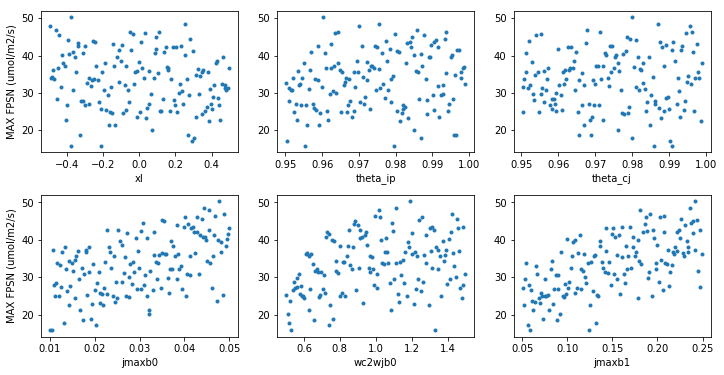

In [4]:
f = da['FPSN'].groupby('ens').max(dim=xr.ALL_DIMS).values
plt.figure(figsize=[12,6])
i = 0
for v in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[v],f,'.')
    plt.xlabel(v)
    if (i==1)|(i==4):
        plt.ylabel('MAX FPSN (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

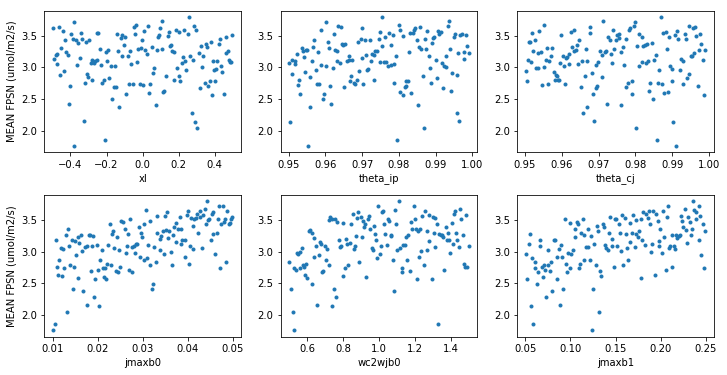

In [5]:
f = da['FPSN'].groupby('ens').mean(dim=xr.ALL_DIMS).values
plt.figure(figsize=[12,6])
i = 0
for v in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[v],f,'.')
    plt.xlabel(v)
    if (i==1)|(i==4):
        plt.ylabel('MEAN FPSN (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

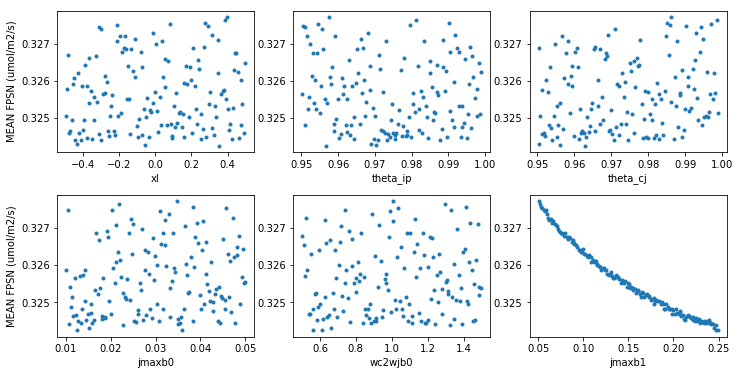

In [76]:
f = da['FV'].groupby('ens').mean(dim=xr.ALL_DIMS).values
plt.figure(figsize=[12,6])
i = 0
for v in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[v],f,'.')
    plt.xlabel(v)
    if (i==1)|(i==4):
        plt.ylabel('MEAN FPSN (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190723/lib/python3.6/site-packages/xarray/core/groupby.py:713: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


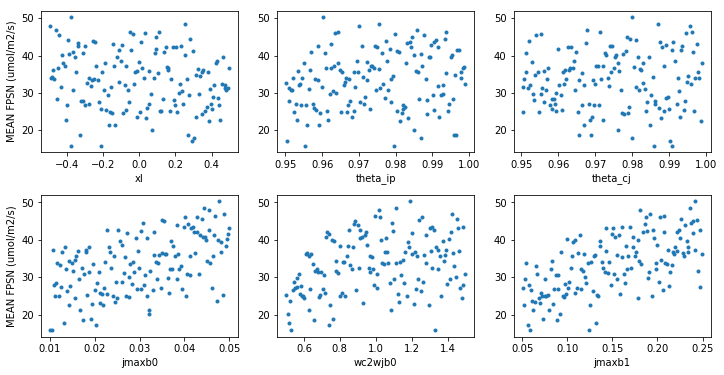

In [98]:
j = sorted(da['jmaxb1'].values)
jmax = j[-3]
ix = da['jmaxb1'].values==jmax
ee = da['ens'][ix]
x = da['FSDSVD']+da['FSDSVI']

ix1 = np.ndarray.flatten((x>300).values)
ix2 = da['time.month']==6
ix = np.logical_and(ix1,ix2)
v  = da['VPD']
q=np.quantile(v[ix],[0.25,0.5])
ix3 = np.ndarray.flatten(np.logical_and(v>q[0],v<q[1]).values)

ix0 = np.logical_and(ix1,ix2)
ix = np.logical_and(ix0,ix3)

fcap = da['FPSN'].where(ix).groupby('ens').mean().values

plt.figure(figsize=[12,6])
i = 0
for v in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[v],fcap,'.')
    plt.xlabel(v)
    if (i==1)|(i==4):
        plt.ylabel('MEAN FPSN (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)


In [94]:
iav = [np.std(da['FPSN'].isel(ens=ee).groupby('time.year').mean(dim=xr.ALL_DIMS).values[0:10]) for ee in np.arange(150)]
fmax = da['FPSN'].groupby('ens').max(dim=xr.ALL_DIMS).values

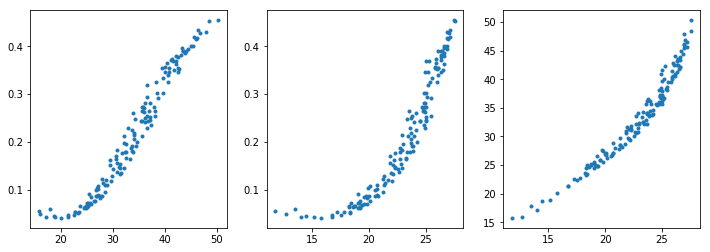

In [100]:
plt.figure(figsize=[12,4])
plt.subplot(131)
plt.plot(fmax,iav,'.')
plt.subplot(132)
plt.plot(fcap,iav,'.')
plt.subplot(133)
plt.plot(fcap,fmax,'.')

In [125]:
over20 = np.array([np.sum(da['FPSN'].isel(ens=ee)>20).values for ee in np.arange(150)])/25532
over25 = np.array([np.sum(da['FPSN'].isel(ens=ee)>25).values for ee in np.arange(150)])/25532

Text(0,0.5,'GPP IAV (umol/m2/s)')

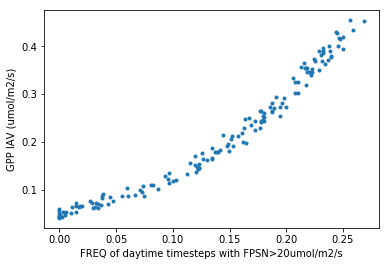

In [136]:
plt.plot(over20,iav,'.')
plt.xlabel('FREQ of daytime timesteps with FPSN>20umol/m2/s')
plt.ylabel('GPP IAV (umol/m2/s)')

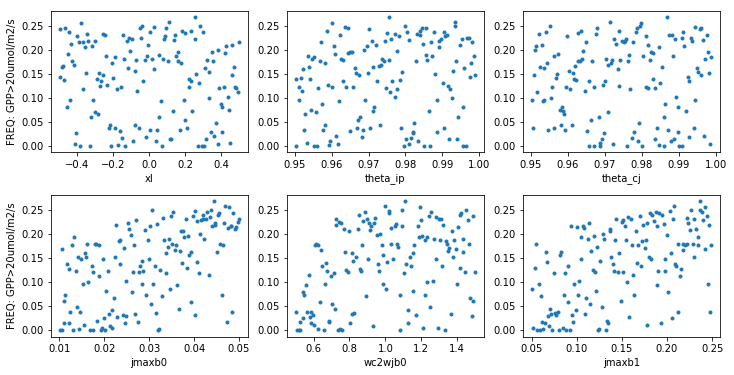

In [133]:
plt.figure(figsize=[12,6])
i = 0
for v in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[v],over20,'.')
    plt.xlabel(v)
    if (i==1)|(i==4):
        plt.ylabel('FREQ: GPP>20umol/m2/s')
plt.subplots_adjust(hspace=0.3)

In [113]:
over0 = [np.sum(da['FPSN'].isel(ens=ee)>0).values for ee in np.arange(150)]

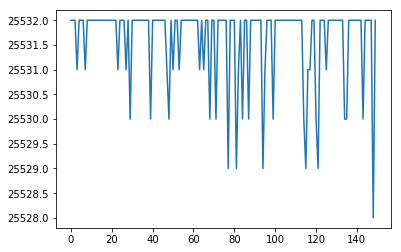

In [114]:
plt.plot(over0)

<BarContainer object of 40 artists>

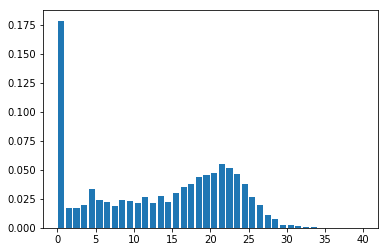

In [10]:
ee=11
ix0 = da['time.month']==6
x = np.ndarray.flatten(da['RH_LEAF'].isel(ens=ee).values)
f = np.ndarray.flatten(da['FPSN'].isel(ens=ee).values)
v = np.ndarray.flatten(da['VPD'].values)/1000
fs = np.ndarray.flatten((da['FSDSVD'].values+da['FSDSVI'].values))
ix = fs>300

bins = np.arange(41)
h = np.histogram(f[ix],bins)
h = h[0]/np.sum(h[0])
b = 0.5+bins[:-1]
plt.bar(b,h)

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

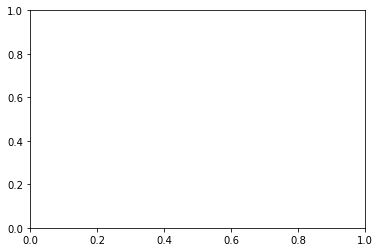

In [131]:
ix0 = np.logical_and(da['time.month']==6,da['time.month']==2006)
da['TLAI'][ix0].plot()